In [1]:
from math import exp
from random import random
from copy import deepcopy
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

In [55]:
def normalization_factors(xss):
    factors = [float('-inf')] * len(xss)
    for xs in xss:
        for i, x in enumerate(xs):
            factors[i] = max(factors[i], abs(x))
    return factors
def normalized_input(xss, factors):
    return [[x / f for x, f in zip(xs, factors)] for xs in xss]

In [56]:
def read_train(filename):
    with open(filename) as f:
        data = f.readlines()
    
    # read column headers
    line = [item.strip() for item in data[0].split(',')]
    attr_vars = line[:-1]
    class_var = line[-1]
    
    class_count = 0
    class_name_to_idx = {}
    class_idx_to_name = []
    
    x_train = []
    y_train = []

    # read train data
    for line in data[1:]:
        line = [item.strip() for item in line.split(',')]
        c = line[-1]
        if c not in class_name_to_idx:
            class_name_to_idx[c] = class_count
            class_idx_to_name.append(c)
            class_count += 1
        x_train.append([float(val) for val in line[:-1]])
        y_train.append(class_name_to_idx[c])
        
    n_factors = normalization_factors(x_train)
    x_train = normalized_input(x_train, n_factors)
    
    return attr_vars, class_var, class_name_to_idx, class_idx_to_name, x_train, y_train, n_factors

In [57]:
def read_test(filename, n_factors):
    with open(filename) as f:
        data = f.readlines()
    
    x_test = []

    # read test data
    for line in data[1:]:
        line = [item.strip() for item in line.split(',')]
        x_test.append([float(val) for val in line])
    
    return normalized_input(x_test, n_factors)

In [58]:
sigmoid = lambda xs: [1 / (1 + exp(-x)) for x in xs]
# sigmoid_prime = lambda x: (exp(x) / (1 + exp(x))) / (1 + exp(x))
sigmoid_prime = lambda x: 1 / (1 + exp(-x)) * (1 - 1 / (1 + exp(-x)))

relu = lambda xs: [x if x > 0 else 0 for x in xs]
relu_prime = lambda x: 1 if x > 0 else 0

def softmax(xs):
    numer = [exp(x) for x in xs]
    denom = sum(numer)
    return [x / denom for x in numer]

def sel(network_output, label):
    return 1 - 2 * network_output[label] + sum([val**2 for val in network_output])

def softmax_sel_prime(k, layer, label):
    res = 0
    for i, val in enumerate(layer):
        if k == i:
            ltemp = exp(val) / sum([exp(x) for x in layer]) * (1 - exp(val) / sum([exp(x) for x in layer]))
        else:
            ltemp = -exp(val) * exp(layer[k]) / sum([exp(x) for x in layer])**2
        if i == label:
            rtemp = 2 + 2 * exp(val) / sum([exp(x) for x in layer])
        else:
            rtemp = 2 * exp(val) / sum([exp(x) for x in layer])
        res += ltemp * rtemp
    return res

In [59]:
def initialize_weights(layer_sizes):
    return [[[random() 
             for _ in range(rsize)] 
            for _ in range(lsize + 1)] 
           for lsize, rsize in zip(layer_sizes, layer_sizes[1:])]

In [60]:
def update_weights(layer_sizes, weights, deltas, layers, learning_rate):
    for i in range(1, len(layer_sizes)):
        for j in range(layer_sizes[i - 1] + 1):
            for k in range(layer_sizes[i]):
                weights[i - 1][j][k] -= learning_rate * (layers[i - 1] + [1])[j] * deltas[i - 1][k]

In [61]:
def backprop(weights, layer_sizes, activation, activation_prime, final_act, loss, final_act_loss_prime, batch_size, learning_rate, x_train, y_train):    
    for i, (x, y) in enumerate(zip(x_train, y_train)):
        if i % batch_size == 0:
            old_weights = deepcopy(weights)
            
        layers, layers_pre_act = evaluate(layer_sizes, activation, final_act, old_weights, x)
        
        # compute deltas in reverse order
        deltas = [[final_act_loss_prime(k, layers_pre_act[-1], y) 
                   for k in range(layer_sizes[-1])]]
        for j in range(len(layer_sizes) - 2, 0, -1):
            deltas.append([sum([activation_prime(layers_pre_act[j][k]) * old_weights[j][k][l] * deltas[-1][l] 
                                  for l in range(layer_sizes[j + 1])]) 
                                 for k in range(layer_sizes[j])])
        deltas.reverse()
        
        # normalize gradients
        deltas = [[delta / len(x_train) for delta in deltas_layer] for deltas_layer in deltas]
        
        update_weights(layer_sizes, weights, deltas, layers, learning_rate)
    
    return weights

In [9]:
def evaluate(layer_sizes, activation, final_act, weights, x):
    layers_pre_act = [x]
    layers = [x]
    layer = x

    for i, (lsize, rsize) in enumerate(zip(layer_sizes, layer_sizes[1:])):
        layer_pre_act = [sum([weights[i][j][k] * (layer + [1])[j] 
                              for j in range(lsize + 1)]) 
                         for k in range(rsize)]
        layers_pre_act.append(layer_pre_act)
        
        if i > len(layer_sizes) - 3:
            act = final_act
        else:
            act = activation
        layer = act(layer_pre_act)
        layers.append(layer)
        
    return layers, layers_pre_act

In [19]:
def classify(class_idx_to_name, layer_sizes, activation, final_act, weights, x):
    layers, layers_pre_act = evaluate(layer_sizes, activation, final_act, weights, x)
    final_layer = layers[-1]
    return class_idx_to_name[max(range(layer_sizes[-1]), key=lambda x: final_layer[x])]

In [11]:
train_file = "train_diabetes.txt"
test_file = "test_diabetes.txt"
output_file = "out_diabetes.txt"

In [12]:
attr_vars, class_var, class_name_to_idx, class_idx_to_name, x_train, y_train, n_factors = read_train(train_file)
x_test = read_test(test_file, n_factors)

In [51]:
layer_sizes = (8, 7, 2)
batch_size = 20

learning_rate = 1
epochs = 40

activation = sigmoid
# activation = relu
activation_prime = sigmoid_prime
# activation_prime = relu_prime
final_act = softmax
loss = sel
final_act_loss_prime = softmax_sel_prime

In [52]:
weights = initialize_weights(layer_sizes)
initial_weights = deepcopy(weights)
losses = []
l_rate = learning_rate

for e in trange(epochs):
    # update learning rate
    l_rate = learning_rate / (epochs + 1)
    
    # backprop using all train data
    weights = backprop(
        weights,
        layer_sizes, 
        activation, 
        activation_prime, 
        final_act, 
        loss, 
        final_act_loss_prime, 
        batch_size, 
        l_rate, 
        x_train, 
        y_train)

    # calculate total loss
    temp = 0
    for x, y in zip(x_train, y_train):
        layers, _ = evaluate(layer_sizes, activation, final_act, weights, x)
        temp += loss(layers[-1], y)
    losses.append(temp)

100%|███████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.11it/s]


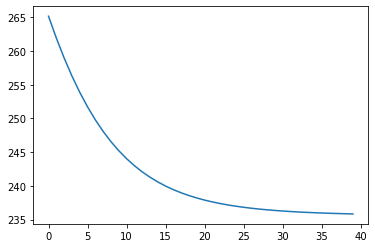

In [53]:
fig, ax = plt.subplots()
ax.plot(range(epochs), losses)

In [54]:
res = []
for x in x_test:
    y = classify(class_idx_to_name, layer_sizes, activation, final_act, weights, x)
    res.append(y)
    
with open(output_file, 'w') as f:
    print('\n'.join(res))
    f.write('\n'.join(res))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
